In [1]:
import sys
sys.path.insert(0, "/work/04233/sw33286/AIDA-SCRIPTS")

In [2]:
import os
import random
import shutil
import numpy as np

import tensorflow as tf
from tensorflow.contrib.rnn import LSTMCell, MultiRNNCell, DropoutWrapper

from helpers import Indexer, batch
from itertools import chain, product

### Prepare data

In [3]:
SHARED_SIZE = 2 # size of noise (or, common vocab for all types).

TYPES = ['ANIMAL','VEHICLE','NATURE','FURNITURE','FRUIT']
SHARED_VOCAB = ['share'+str(i+1) for i in range(SHARED_SIZE)]
TYPE2VOCAB = {'ANIMAL': ['cat','dog','pig','horse','deer']            + SHARED_VOCAB,
              'VEHICLE': ['car','bike','motorcycle','train','bus']    + SHARED_VOCAB,
              'NATURE': ['hill','mountain','lake','river','valley']   + SHARED_VOCAB,
              'FURNITURE': ['stool','table','closet','cabinet','bed'] + SHARED_VOCAB,
              'FRUIT': ['apple','pear','strawberry','grape','tomato'] + SHARED_VOCAB}
VOCAB = list(chain.from_iterable(TYPE2VOCAB.values()))

indexer = Indexer()
indexer.get_index('PAD')
for word in VOCAB:
    indexer.get_index(word)

In [4]:
DOC_LEN = 5
SENT_FROM_LEN = 5
SENT_TO_LEN = 15
CTX_LEN = ((SENT_TO_LEN-SENT_FROM_LEN)//2)*DOC_LEN

def to_sent(code):
    return [indexer.get_object(idx) for idx in code]

def get_rand_sent_code(sem_type, sent_len):
    return [indexer.get_index(np.random.choice(TYPE2VOCAB[sem_type])) for _ in range(sent_len)]

def get_mixture(type1, type2):
    doc_a = [get_rand_sent_code(type1, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_b = [get_rand_sent_code(type2, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_mix = np.array(doc_a[:] + doc_b[:])
    doc_lbs = np.array([0]*DOC_LEN + [1]*DOC_LEN)
    indices = list(range(DOC_LEN*2))
    random.shuffle(indices)
    doc_mix = doc_mix[indices]
    doc_lbs = doc_lbs[indices]
    return doc_a, doc_b, doc_mix, doc_lbs
    
def batch_mixture(doc_a, doc_b, doc_mix, k):
    batch_x1, batch_x2, batch_ctx, batch_y = [], [], [], []
    ys = [1,0,0,1]
    doc_mix_flat = list(chain.from_iterable(doc_mix))
    doc_mix_len = len(doc_mix_flat)
    doc_mix_padded = np.array(doc_mix_flat[:CTX_LEN]) if doc_mix_len>=CTX_LEN else np.array(doc_mix_flat+[0]*(CTX_LEN-doc_mix_len))
    for _ in range(k):
        for i,(da,db) in enumerate(product([doc_a,doc_b],[doc_a,doc_b])):
            batch_x1.append(random.choice(da))
            batch_x2.append(random.choice(db))
            batch_y.append(ys[i])
    return batch(batch_x1), batch(batch_x2), np.array([doc_mix_padded]), np.array(batch_y)

def get_batch(n=40):
    if n%4!=0:
        raise ValueError('The current generation scheme only supports multiples of 4 for batch size!')
    type1, type2 = np.random.choice(TYPES, 2, replace=False)
    doc_a, doc_b, doc_mix, _ = get_mixture(type1, type2) # document labels isn't germane here.
    (batch_x1,batch_x1_len), (batch_x2,batch_x2_len), batch_ctx, batch_y = batch_mixture(doc_a,doc_b,doc_mix,n//4)
    return batch_x1,batch_x1_len,batch_x2,batch_x2_len,batch_ctx,batch_y

### Bi-LSTM classifier w/o context reader

In [7]:
tf.reset_default_graph()

sess = tf.InteractiveSession()

VOCAB_SIZE = len(indexer)
EMB_SIZE = 20
HID_SIZE = 10
NUM_LAYERS = 2
KEEP_PROB = 0.7

# hyperparams for cnn context reader.
FILTER_SIZES = [3,4,5]
NUM_FILTERS = 10
NUM_CHANNELS = 1

input_x1 = tf.placeholder(tf.int32, [None, None], name='input_x1') # <max-time, batch-size>
input_x2 = tf.placeholder(tf.int32, [None, None], name='input_x2')
input_x1_length = tf.placeholder(tf.int32, [None], name='input_x1_length')
input_x2_length = tf.placeholder(tf.int32, [None], name='input_x2_length')
input_y  = tf.placeholder(tf.int32, [None], name='input_y')

keep_prob = tf.placeholder(tf.float32, name="keep_prob")

with tf.variable_scope('Embeddings'):
    embeddings = tf.get_variable('embeddings', [VOCAB_SIZE, EMB_SIZE], 
                                 initializer=tf.contrib.layers.xavier_initializer())
    input_x1_embedded = tf.nn.embedding_lookup(embeddings, input_x1) # <max-time, batch-size, emb-size>
    input_x2_embedded = tf.nn.embedding_lookup(embeddings, input_x2)

cell = MultiRNNCell([DropoutWrapper(LSTMCell(HID_SIZE),output_keep_prob=keep_prob)]*NUM_LAYERS) 

def run_lstm(cell, inputs, inputs_length): # lstm-out size *= 2 by bidirectionality.
    ((fw_outputs,bw_outputs), # <max-time, batch-size, hid-size>, attention later if needed.
     (fw_final_state,bw_final_state)) = ( # <batch-size, hid-size>
        tf.nn.bidirectional_dynamic_rnn(cell_fw=cell,
                                        cell_bw=cell,
                                        inputs=inputs,
                                        sequence_length=inputs_length,
                                        dtype=tf.float32, time_major=True)
    )
    return tf.concat([tf.concat([fw_state_tuple.h,bw_state_tuple.h], 1) # lstm-out size *= NUM_LAYERS by stacking.
                      for fw_state_tuple,bw_state_tuple in zip(fw_final_state,bw_final_state)], 1)
    
with tf.variable_scope('Bi-LSTM') as scope:
    final_state_x1 = run_lstm(cell, input_x1_embedded, input_x1_length)
    scope.reuse_variables() # both sentence inputs share the same weights.
    final_state_x2 = run_lstm(cell, input_x2_embedded, input_x2_length)

final_vec_size = HID_SIZE*2*2
final_vec_x1 = final_state_x1
final_vec_x2 = final_state_x2
W_bi = tf.get_variable('W_bi', [final_vec_size, final_vec_size], initializer=tf.contrib.layers.xavier_initializer())
scores = tf.nn.sigmoid(tf.diag_part(tf.matmul(tf.matmul(final_vec_x1,W_bi),tf.transpose(final_vec_x2))),name='scores')
predictions = tf.cast(tf.round(scores), tf.int32, name='predictions')     

with tf.name_scope('Loss'):
    losses = tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.cast(input_y, tf.float32), logits=scores)
    loss = tf.reduce_mean(losses, name='loss')

with tf.name_scope('Accuracy'):
    correct_predictions = tf.equal(predictions, input_y)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32), name='accuracy')
    
global_step = tf.Variable(0, name='global_step', trainable=False)
optimizer = tf.train.AdamOptimizer(1e-5)
grads_and_vars = optimizer.compute_gradients(loss)
train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step, name='train_op')

sess.run(tf.global_variables_initializer())

In [8]:
NUM_EPOCHS = 100
NUM_BATCHES = 1000
VERBOSE = 100

loss_track, accuracy_track = [], []
for e in range(NUM_EPOCHS):
    print('Epoch ', e+1)
    print('\n')
    curr_loss_track, curr_accuracy_track = [], []
    for _ in range(NUM_BATCHES):
        batch_x1, batch_x1_length, batch_x2, batch_x2_length, _, batch_y = get_batch() # context is out
        fd = {input_x1:batch_x1, input_x1_length:batch_x1_length,
              input_x2:batch_x2, input_x2_length:batch_x2_length,
              input_y:batch_y,
              keep_prob:KEEP_PROB}
        _, step, loss_, accuracy_ = sess.run([train_op, global_step, loss, accuracy], feed_dict=fd)
        curr_loss_track.append(loss_)
        curr_accuracy_track.append(accuracy_)
        if step%VERBOSE==0:
            print('  batch loss & accuracy at step {}: <{}, {}>'.format(step, loss_, accuracy_))
    print('\n')
    print('  epoch mean loss & accuracy: <{}, {}>'.format(np.mean(curr_loss_track),np.mean(curr_accuracy_track)))
    print('\n')    
    loss_track += curr_loss_track
    accuracy_track += curr_accuracy_track

Epoch  1


  batch loss & accuracy at step 100: <0.7234295606613159, 0.5>
  batch loss & accuracy at step 200: <0.7241232991218567, 0.5>
  batch loss & accuracy at step 300: <0.7232618927955627, 0.42500001192092896>
  batch loss & accuracy at step 400: <0.7243558168411255, 0.42500001192092896>
  batch loss & accuracy at step 500: <0.7240636348724365, 0.375>
  batch loss & accuracy at step 600: <0.7242727875709534, 0.4750000238418579>
  batch loss & accuracy at step 700: <0.7231428623199463, 0.550000011920929>
  batch loss & accuracy at step 800: <0.7223575115203857, 0.6000000238418579>
  batch loss & accuracy at step 900: <0.723676323890686, 0.4750000238418579>
  batch loss & accuracy at step 1000: <0.7221702337265015, 0.625>


  epoch mean loss & accuracy: <0.7235721349716187, 0.49004998803138733>


Epoch  2


  batch loss & accuracy at step 1100: <0.7229317426681519, 0.5249999761581421>
  batch loss & accuracy at step 1200: <0.7226206064224243, 0.5000000596046448>
  batch loss & accu

  batch loss & accuracy at step 11000: <0.6954801082611084, 0.5>


  epoch mean loss & accuracy: <0.664609432220459, 0.588200032711029>


Epoch  12


  batch loss & accuracy at step 11100: <0.688736617565155, 0.5>
  batch loss & accuracy at step 11200: <0.6881405115127563, 0.5>
  batch loss & accuracy at step 11300: <0.6893867254257202, 0.5>
  batch loss & accuracy at step 11400: <0.6870636343955994, 0.5>
  batch loss & accuracy at step 11500: <0.6882453560829163, 0.5>
  batch loss & accuracy at step 11600: <0.6179742813110352, 0.75>
  batch loss & accuracy at step 11700: <0.6825730800628662, 0.5>
  batch loss & accuracy at step 11800: <0.5685113668441772, 0.7749999761581421>
  batch loss & accuracy at step 11900: <0.6856212615966797, 0.5>
  batch loss & accuracy at step 12000: <0.6097447872161865, 0.75>


  epoch mean loss & accuracy: <0.6595808267593384, 0.5959749817848206>


Epoch  13


  batch loss & accuracy at step 12100: <0.6893400549888611, 0.5250000357627869>
  batch loss & ac

  batch loss & accuracy at step 21200: <0.6057773232460022, 0.75>
  batch loss & accuracy at step 21300: <0.6431083083152771, 0.7250000238418579>
  batch loss & accuracy at step 21400: <0.620456874370575, 0.75>
  batch loss & accuracy at step 21500: <0.6950526237487793, 0.5>
  batch loss & accuracy at step 21600: <0.6038767099380493, 0.75>
  batch loss & accuracy at step 21700: <0.6148895025253296, 0.75>
  batch loss & accuracy at step 21800: <0.6246306896209717, 0.75>
  batch loss & accuracy at step 21900: <0.6921167373657227, 0.5>
  batch loss & accuracy at step 22000: <0.6137620806694031, 0.7250000238418579>


  epoch mean loss & accuracy: <0.6218410730361938, 0.7283249497413635>


Epoch  23


  batch loss & accuracy at step 22100: <0.6017024517059326, 0.75>
  batch loss & accuracy at step 22200: <0.6157330274581909, 0.75>
  batch loss & accuracy at step 22300: <0.7992806434631348, 0.5>
  batch loss & accuracy at step 22400: <0.5157048106193542, 0.9749999642372131>
  batch loss & ac

  batch loss & accuracy at step 32000: <0.5036198496818542, 1.0>


  epoch mean loss & accuracy: <0.6173397302627563, 0.7359000444412231>


Epoch  33


  batch loss & accuracy at step 32100: <0.8127759695053101, 0.5>
  batch loss & accuracy at step 32200: <0.5984942317008972, 0.75>
  batch loss & accuracy at step 32300: <0.5985208749771118, 0.75>
  batch loss & accuracy at step 32400: <0.601996123790741, 0.75>
  batch loss & accuracy at step 32500: <0.5988359451293945, 0.75>
  batch loss & accuracy at step 32600: <0.6937069892883301, 0.5>
  batch loss & accuracy at step 32700: <0.5986043214797974, 0.75>
  batch loss & accuracy at step 32800: <0.5037893056869507, 1.0>
  batch loss & accuracy at step 32900: <0.5149915814399719, 1.0>
  batch loss & accuracy at step 33000: <0.8133546710014343, 0.5>


  epoch mean loss & accuracy: <0.6126174926757812, 0.7458250522613525>


Epoch  34


  batch loss & accuracy at step 33100: <0.5994609594345093, 0.75>
  batch loss & accuracy at step 33200: <0

  batch loss & accuracy at step 43000: <0.8132561445236206, 0.5>


  epoch mean loss & accuracy: <0.6105843782424927, 0.7518250346183777>


Epoch  44


  batch loss & accuracy at step 43100: <0.5981835722923279, 0.75>
  batch loss & accuracy at step 43200: <0.5032055974006653, 1.0>
  batch loss & accuracy at step 43300: <0.5990280508995056, 0.75>
  batch loss & accuracy at step 43400: <0.5982213616371155, 0.75>
  batch loss & accuracy at step 43500: <0.813260018825531, 0.5>
  batch loss & accuracy at step 43600: <0.598182201385498, 0.75>
  batch loss & accuracy at step 43700: <0.599306046962738, 0.75>
  batch loss & accuracy at step 43800: <0.5982967615127563, 0.75>
  batch loss & accuracy at step 43900: <0.5987032651901245, 0.75>
  batch loss & accuracy at step 44000: <0.6928637623786926, 0.5>


  epoch mean loss & accuracy: <0.612709105014801, 0.7465250492095947>


Epoch  45


  batch loss & accuracy at step 44100: <0.5982178449630737, 0.75>
  batch loss & accuracy at step 44200: <0.

  batch loss & accuracy at step 54100: <0.5032094717025757, 1.0>
  batch loss & accuracy at step 54200: <0.5032049417495728, 1.0>
  batch loss & accuracy at step 54300: <0.6931200623512268, 0.5>
  batch loss & accuracy at step 54400: <0.5983358025550842, 0.75>
  batch loss & accuracy at step 54500: <0.5032044649124146, 1.0>
  batch loss & accuracy at step 54600: <0.5981857776641846, 0.75>
  batch loss & accuracy at step 54700: <0.5032050013542175, 1.0>
  batch loss & accuracy at step 54800: <0.5982220768928528, 0.75>
  batch loss & accuracy at step 54900: <0.6931503415107727, 0.5>
  batch loss & accuracy at step 55000: <0.5032045841217041, 1.0>


  epoch mean loss & accuracy: <0.6093140840530396, 0.7520999908447266>


Epoch  56


  batch loss & accuracy at step 55100: <0.8132617473602295, 0.5>
  batch loss & accuracy at step 55200: <0.5984848737716675, 0.75>
  batch loss & accuracy at step 55300: <0.503224790096283, 1.0>
  batch loss & accuracy at step 55400: <0.8132654428482056, 0.5>


  batch loss & accuracy at step 65200: <0.5982351899147034, 0.75>
  batch loss & accuracy at step 65300: <0.598423421382904, 0.75>
  batch loss & accuracy at step 65400: <0.5982223153114319, 0.75>
  batch loss & accuracy at step 65500: <0.5032607316970825, 1.0>
  batch loss & accuracy at step 65600: <0.5986735820770264, 0.75>
  batch loss & accuracy at step 65700: <0.5988849401473999, 0.75>
  batch loss & accuracy at step 65800: <0.5981641411781311, 0.75>
  batch loss & accuracy at step 65900: <0.598185658454895, 0.75>
  batch loss & accuracy at step 66000: <0.598160445690155, 0.75>


  epoch mean loss & accuracy: <0.6145231127738953, 0.7441250085830688>


Epoch  67


  batch loss & accuracy at step 66100: <0.598176896572113, 0.75>
  batch loss & accuracy at step 66200: <0.6931458711624146, 0.5>
  batch loss & accuracy at step 66300: <0.5032044649124146, 1.0>
  batch loss & accuracy at step 66400: <0.6931472420692444, 0.5>
  batch loss & accuracy at step 66500: <0.5981816649436951, 0.7

  batch loss & accuracy at step 76300: <0.598098635673523, 0.75>
  batch loss & accuracy at step 76400: <0.5032044649124146, 1.0>
  batch loss & accuracy at step 76500: <0.6931471824645996, 0.5>
  batch loss & accuracy at step 76600: <0.5982385277748108, 0.75>
  batch loss & accuracy at step 76700: <0.5982347726821899, 0.75>
  batch loss & accuracy at step 76800: <0.5982040762901306, 0.75>
  batch loss & accuracy at step 76900: <0.598239004611969, 0.75>
  batch loss & accuracy at step 77000: <0.5981837511062622, 0.75>


  epoch mean loss & accuracy: <0.6133915781974792, 0.7426249980926514>


Epoch  78


  batch loss & accuracy at step 77100: <0.5981873869895935, 0.75>
  batch loss & accuracy at step 77200: <0.5981847047805786, 0.75>
  batch loss & accuracy at step 77300: <0.693156898021698, 0.5>
  batch loss & accuracy at step 77400: <0.8132617473602295, 0.5>
  batch loss & accuracy at step 77500: <0.5032044649124146, 1.0>
  batch loss & accuracy at step 77600: <0.5981900691986084, 0.7

  batch loss & accuracy at step 87400: <0.5982081294059753, 0.75>
  batch loss & accuracy at step 87500: <0.8132618069648743, 0.5>
  batch loss & accuracy at step 87600: <0.5981782078742981, 0.75>
  batch loss & accuracy at step 87700: <0.5981761813163757, 0.75>
  batch loss & accuracy at step 87800: <0.598231852054596, 0.75>
  batch loss & accuracy at step 87900: <0.8132617473602295, 0.5>
  batch loss & accuracy at step 88000: <0.5985861420631409, 0.75>


  epoch mean loss & accuracy: <0.6132006645202637, 0.7451750040054321>


Epoch  89


  batch loss & accuracy at step 88100: <0.5981951355934143, 0.75>
  batch loss & accuracy at step 88200: <0.5032044649124146, 1.0>
  batch loss & accuracy at step 88300: <0.6931219100952148, 0.5>
  batch loss & accuracy at step 88400: <0.5981842875480652, 0.75>
  batch loss & accuracy at step 88500: <0.5981783270835876, 0.75>
  batch loss & accuracy at step 88600: <0.5032044649124146, 1.0>
  batch loss & accuracy at step 88700: <0.8132618069648743, 0

  batch loss & accuracy at step 98500: <0.5981876254081726, 0.75>
  batch loss & accuracy at step 98600: <0.6931471228599548, 0.5>
  batch loss & accuracy at step 98700: <0.5032044649124146, 1.0>
  batch loss & accuracy at step 98800: <0.6928820013999939, 0.5>
  batch loss & accuracy at step 98900: <0.5981883406639099, 0.75>
  batch loss & accuracy at step 99000: <0.5981782674789429, 0.75>


  epoch mean loss & accuracy: <0.6046968698501587, 0.7600999474525452>


Epoch  100


  batch loss & accuracy at step 99100: <0.5981758832931519, 0.75>
  batch loss & accuracy at step 99200: <0.5032047033309937, 1.0>
  batch loss & accuracy at step 99300: <0.5983096957206726, 0.75>
  batch loss & accuracy at step 99400: <0.5981864333152771, 0.75>
  batch loss & accuracy at step 99500: <0.5982046127319336, 0.75>
  batch loss & accuracy at step 99600: <0.5981771349906921, 0.75>
  batch loss & accuracy at step 99700: <0.6931468844413757, 0.5>
  batch loss & accuracy at step 99800: <0.5982020497322083,

In [9]:
# # Save model

# saver = tf.train.Saver()
# save_dir = "/work/04233/sw33286/AIDA-MODEL-SAVE/MOCK2/"
# save_path = save_dir + "stacked-bilstm-mock-01"
# saver.save(sess, save_path)

'/work/04233/sw33286/AIDA-MODEL-SAVE/MOCK2/stacked-bilstm-mock-01'

### Bi-LSTM + HAC

In [10]:
import numpy as np
import tensorflow as tf
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from collections import defaultdict
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline
import colorama
from colorama import Style

class ClfHAC:
    
    def __init__(self, clf_dir, clf_filename):
        self.sess = tf.Session()
        saver = tf.train.import_meta_graph(clf_dir + clf_filename)
        saver.restore(self.sess, tf.train.latest_checkpoint(clf_dir))
        self.graph = tf.get_default_graph()
        self.input_x1 = self.graph.get_tensor_by_name('input_x1:0')
        self.input_x2 = self.graph.get_tensor_by_name('input_x2:0')
        self.input_x1_length = self.graph.get_tensor_by_name('input_x1_length:0')
        self.input_x2_length = self.graph.get_tensor_by_name('input_x2_length:0')
        self.input_y = self.graph.get_tensor_by_name('input_y:0')
        self.keep_prob = self.graph.get_tensor_by_name('keep_prob:0')

        self.scores = self.graph.get_tensor_by_name('scores:0')
        self.predictions = self.graph.get_tensor_by_name('predictions:0')
        self.loss = self.graph.get_tensor_by_name('Loss/loss:0')
        self.accuracy = self.graph.get_tensor_by_name('Accuracy/accuracy:0')
        self.global_step = self.graph.get_tensor_by_name('global_step:0')
        self.train_op = self.graph.get_tensor_by_name('train_op:0')
     
    def dist(self, x1, x2):
        x1, x1_len = batch([x1])
        x2, x2_len = batch([x2])
        fd = {self.input_x1:x1, self.input_x1_length:x1_len,
              self.input_x2:x2, self.input_x2_length:x2_len,
              self.keep_prob:1.0}
        conf = self.sess.run(self.scores, feed_dict=fd)
        return 1-conf[0]
    
    def evaluate(self, doc_mix, doc_lbs, method='average', plot=True):
        doc_mix_sq, _ = batch(doc_mix)
        doc_mix_sq = doc_mix_sq.T
        doc_mix_clust = linkage(doc_mix_sq, method=method, metric=self.dist)
        # evaluate by class-based prec/rec/f1
        doc_prd = fcluster(doc_mix_clust, 2, criterion='maxclust') - 1 # predicted assignments (label adjusted)
        acc = clust_accuracy(doc_lbs, doc_prd)
        if plot:
            print('Clustering accuracy = {}'.format(acc))
            print('\n')
            plt.figure(figsize=(25, 10))
            plt.title('Hierarchical Clustering Dendrogram')
            plt.xlabel('sample index')
            plt.ylabel('distance')
            dendrogram(
                doc_mix_clust,
                leaf_rotation=90.,  # rotates the x axis labels
                leaf_font_size=15.,  # font size for the x axis labels
            )
            plt.show() 
            print('True | Pred | Sentence')
            for label,pred_label,code in zip(doc_lbs,doc_prd,doc_mix):
                if label==0:
                    print('\033[1;37;40m {}    | {}    | {}'.format(label,pred_label,to_sent(code)))
                else:
                    print('\033[1;30;47m {}    | {}    | {}'.format(label,pred_label,to_sent(code)))
            print('\n' + Style.RESET_ALL) 
        else:
            return doc_mix_clust, acc

def get_mixture(type1, type2):
    doc_a = [get_rand_sent_code(type1, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_b = [get_rand_sent_code(type2, np.random.randint(SENT_FROM_LEN, SENT_TO_LEN)) for _ in range(DOC_LEN)]
    doc_mix = np.array(doc_a[:] + doc_b[:])
    doc_lbs = np.array([0]*DOC_LEN + [1]*DOC_LEN)
    indices = list(range(DOC_LEN*2))
    random.shuffle(indices)
    doc_mix = doc_mix[indices]
    doc_lbs = doc_lbs[indices]
    return doc_a, doc_b, doc_mix, doc_lbs

def get_rand_mixture():
    type1, type2 = np.random.choice(TYPES, 2, replace=False)
    _,_, doc_mix, doc_lbs = get_mixture(type1, type2)
    return doc_mix, doc_lbs

def flip_clust(clust):
    return np.array([0 if i==1 else 1 for i in clust])

def clust_accuracy(true, pred):
    return max(accuracy_score(true, pred),
               accuracy_score(true, flip_clust(pred)))

def to_sent(code):
    return [indexer.get_object(idx) for idx in code]

In [13]:
restore_dir = "/work/04233/sw33286/AIDA-MODEL-SAVE/MOCK2/"
restore_filename = "stacked-bilstm-mock-01.meta"

In [14]:
clf_hac = ClfHAC(restore_dir, restore_filename)

Clustering accuracy = 1.0




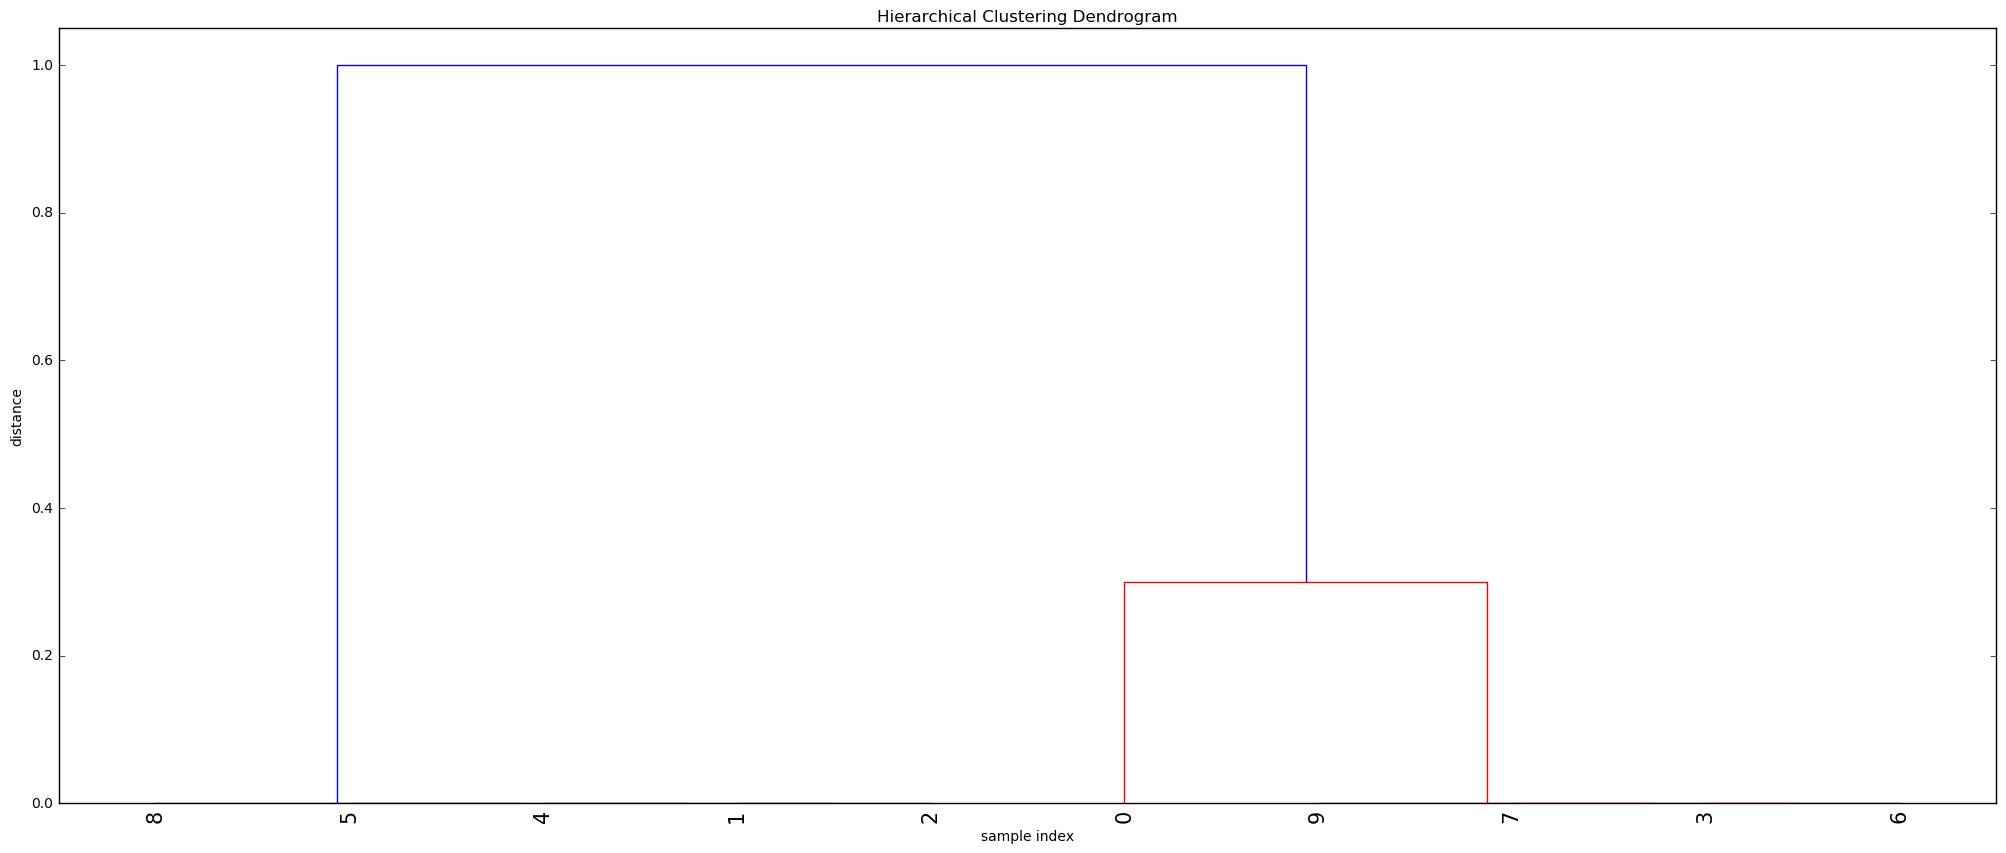

True | Pred | Sentence
 1    | 1    | ['closet', 'closet', 'closet', 'cabinet', 'stool']
 0    | 0    | ['apple', 'pear', 'grape', 'share2', 'share1', 'tomato', 'tomato', 'grape', 'tomato', 'grape']
 0    | 0    | ['pear', 'grape', 'share1', 'tomato', 'strawberry', 'grape', 'strawberry', 'apple', 'grape', 'share2', 'pear']
 1    | 1    | ['bed', 'stool', 'cabinet', 'cabinet', 'bed', 'stool', 'cabinet', 'table', 'cabinet', 'closet', 'closet', 'closet', 'stool', 'cabinet']
 0    | 0    | ['pear', 'tomato', 'strawberry', 'tomato', 'pear']
 0    | 0    | ['strawberry', 'tomato', 'grape', 'strawberry', 'apple', 'tomato', 'share2', 'pear', 'tomato']
 1    | 1    | ['share2', 'table', 'share1', 'closet', 'share2', 'table', 'cabinet', 'share2', 'closet', 'bed', 'cabinet']
 1    | 1    | ['closet', 'cabinet', 'share1', 'cabinet', 'stool', 'cabinet', 'share2', 'bed', 'closet', 'share1', 'table', 'stool']
 0    | 0    | ['apple', 'pear', 'share1', 'share2', 'share2', 'apple', 'apple', 'pear', 'gr

In [16]:
clf_hac.evaluate(*get_rand_mixture())

In [17]:
def rand_evaluation(k=1000):
    accuracies = []
    for _ in range(k):
        _, acc = clf_hac.evaluate(*get_rand_mixture(), plot=False)
        accuracies.append(acc)
    print('Average clustering accuracy over {} samples = {}'.format(k, np.mean(accuracies)))

In [18]:
%%time

rand_evaluation()

Average clustering accuracy over 1000 samples = 0.7148
CPU times: user 54min 20s, sys: 6min 25s, total: 1h 46s
Wall time: 22min 22s
